In [1]:
!nvidia-smi

Sun Sep 13 22:14:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 452.06       Driver Version: 452.06       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 2060   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P0    21W /  N/A |    199MiB /  6144MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

print(os.listdir("../car_class"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['.ipynb_checkpoints', 'best_model.hdf5', 'car_class.ipynb', 'model_last.hdf5', 'model_step2.hdf5', 'sample-submission.csv', 'submission.csv', 'test.zip', 'test_upload', 'train', 'train.csv', 'train.zip']
Python       : 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.18.1
Tensorflow   : 2.3.0
Keras        : 2.4.0


Внесём основные настройки, чтобы было удобнее их перебирать в дальнейшем:

In [3]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS = 5  # эпох на обучение
BATCH_SIZE = 8  # уменьшаем если сеть большая, не поместится в память на GPU
LR = 1e-4
VAL_SPLIT = 0.15  # сколько данных выделяем на тест = 15%

CLASS_NUM = 10  # количество классов в нашей задаче
IMG_SIZE = 224  # какого размера подаем изображения в сеть
IMG_CHANNELS = 3  # у RGB 3 канала
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../car_class/'
PATH = "../car_class/"  # рабочая директория

In [4]:
# Устаналиваем конкретное значение random seed для воспроизводимости
# os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
PYTHONHASHSEED = 0

# Анализ данных 

In [5]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [7]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

Распределение классов достаточно равномерное — это хорошо.

In [8]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../car_class/"+data_zip, "r") as z:
        z.extractall(PATH)

print(os.listdir(PATH))

Распаковываем картинки
['.ipynb_checkpoints', 'best_model.hdf5', 'car_class.ipynb', 'model_last.hdf5', 'model_step2.hdf5', 'sample-submission.csv', 'submission.csv', 'test.zip', 'test_upload', 'train', 'train.csv', 'train.zip']


Пример картинок (random sample)


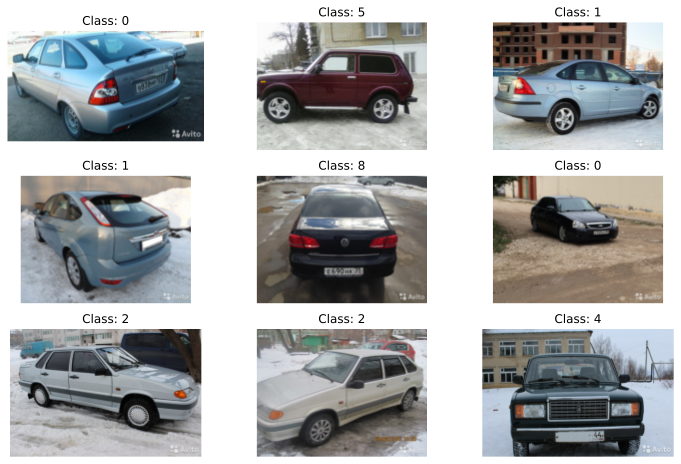

In [9]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12, 8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3, 3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

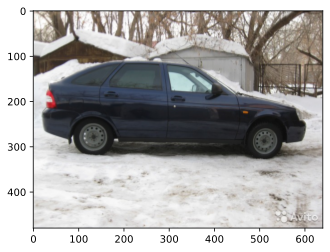

(640, 480)

In [10]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# Подготовка данных

## Аугментация данных

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=5,
    shear_range=0.2,
    zoom_range=[0.75, 1.25],
    brightness_range=[0.5, 2],
    width_shift_range=0.05,
    height_shift_range=0.05,
    validation_split=VAL_SPLIT,  # set validation split
    horizontal_flip=False)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [12]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',  # директория где расположены папки с картинками
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    subset='training')  # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation')  # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


Пример картинок из train_generator


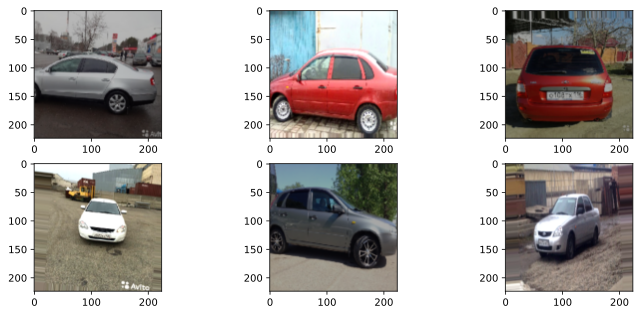

In [13]:
from skimage import io

def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()

x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

# Построение модели

### Загружаем предобученную сеть Xception

In [14]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

In [15]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [16]:
base_model.trainable = False

In [17]:
LR = 0.001

In [18]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [19]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

# Обучение модели

Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [20]:
checkpoint = ModelCheckpoint('best_model.hdf5',
                             monitor='val_accuracy',
                             verbose=1, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=3,
                          restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [21]:
train_generator.samples//train_generator.batch_size

1654

In [22]:
train_generator.samples

13232

In [23]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=test_generator, 
        validation_steps=len(test_generator),
        epochs=EPOCHS,
        callbacks=callbacks_list
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
1654/1654 [==============================] - ETA: 0s - loss: 1.5156 - accuracy: 0.4646
Epoch 00001: saving model to best_model.hdf5
1654/1654 [==============================] - 313s 190ms/step - loss: 1.5156 - accuracy: 0.4646 - val_loss: 1.2187 - val_accuracy: 0.5638
Epoch 2/5
1654/1654 [==============================] - ETA: 0s - loss: 1.2972 - accuracy: 0.5414
Epoch 00002: saving model to best_model.hdf5
1654/1654 [==============================] - 242s 146ms/step - loss: 1.2972 - accuracy: 0.5414 - val_loss: 1.2235 - val_accuracy: 0.5612
Epoch 3/5
1654/1654 [==============================] - ETA: 0s - loss: 1.2440 - accuracy: 0.5599
Epoch 00003: saving model to best_model.hdf5
1654/1654 [==============================] - 242s 146ms/step - loss: 1.2440 - accuracy: 0.5599 - val_loss: 1.1315 - val_accuracy: 0.5955
Epoch 4/5
1654/1654 [==============================] - ETA: 0s - loss: 1.2108 - accurac

In [24]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('model_last.hdf5')
model.load_weights('best_model.hdf5')

In [25]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

Instructions for updating:
Please use Model.evaluate, which supports generators.
292/292 [==============================] - 36s 124ms/step - loss: 1.1002 - accuracy: 0.6024
Accuracy: 60.24%


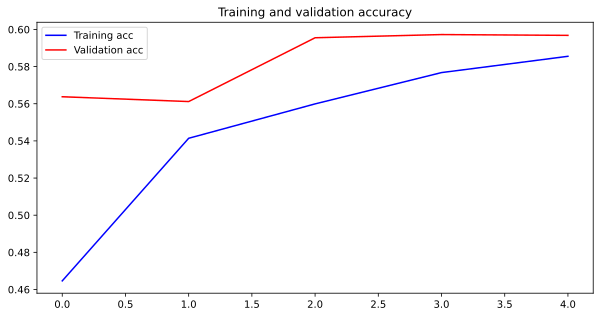

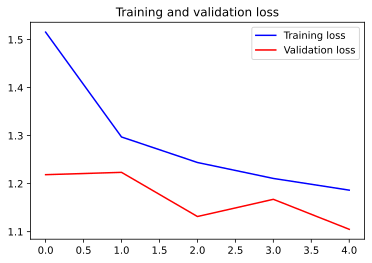

In [26]:
def plot_history(history): 
    plt.figure(figsize=(10,5))
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


plot_history(history)

### Step 2

In [27]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  132


In [28]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [29]:
len(base_model.trainable_variables)

79

In [30]:
LR=0.0009
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [31]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [32]:
# Обучаем
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = 10,
        callbacks = callbacks_list
)

Epoch 1/10
1654/1654 [==============================] - ETA: 0s - loss: 1.0461 - accuracy: 0.6374
Epoch 00001: saving model to best_model.hdf5
1654/1654 [==============================] - 248s 150ms/step - loss: 1.0461 - accuracy: 0.6374 - val_loss: 0.6116 - val_accuracy: 0.7809
Epoch 2/10
1654/1654 [==============================] - ETA: 0s - loss: 0.5618 - accuracy: 0.8091
Epoch 00002: saving model to best_model.hdf5
1654/1654 [==============================] - 248s 150ms/step - loss: 0.5618 - accuracy: 0.8091 - val_loss: 0.4521 - val_accuracy: 0.8398
Epoch 3/10
1654/1654 [==============================] - ETA: 0s - loss: 0.4022 - accuracy: 0.8623
Epoch 00003: saving model to best_model.hdf5
1654/1654 [==============================] - 249s 150ms/step - loss: 0.4022 - accuracy: 0.8623 - val_loss: 0.2971 - val_accuracy: 0.8999
Epoch 4/10
1654/1654 [==============================] - ETA: 0s - loss: 0.3307 - accuracy: 0.8927
Epoch 00004: saving model to best_model.hdf5
1654/1654 [======

In [33]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('model_step2.hdf5')
model.load_weights('best_model.hdf5')

In [34]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

292/292 [==============================] - 36s 123ms/step - loss: 0.2376 - accuracy: 0.9274
Accuracy: 92.74%


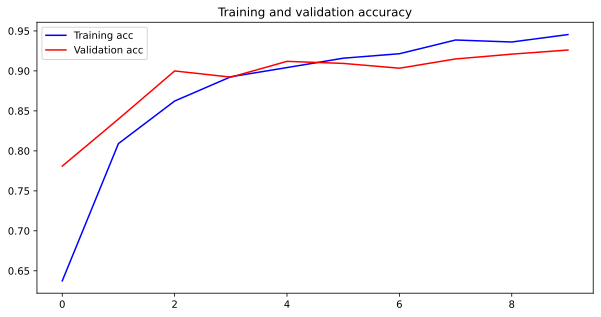

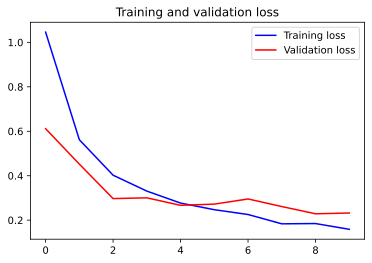

In [35]:
plot_history(history)

### Step 3

In [36]:
base_model.trainable = True

In [37]:
LR=0.00001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [38]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [39]:
# Обучаем
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = 5,
        callbacks = callbacks_list
)

Epoch 1/5
1654/1654 [==============================] - ETA: 0s - loss: 0.1303 - accuracy: 0.9562
Epoch 00001: saving model to best_model.hdf5
1654/1654 [==============================] - 283s 171ms/step - loss: 0.1303 - accuracy: 0.9562 - val_loss: 0.2054 - val_accuracy: 0.9351
Epoch 2/5
1654/1654 [==============================] - ETA: 0s - loss: 0.0979 - accuracy: 0.9666
Epoch 00002: saving model to best_model.hdf5
1654/1654 [==============================] - 283s 171ms/step - loss: 0.0979 - accuracy: 0.9666 - val_loss: 0.1942 - val_accuracy: 0.9416
Epoch 3/5
1654/1654 [==============================] - ETA: 0s - loss: 0.0904 - accuracy: 0.9693
Epoch 00003: saving model to best_model.hdf5
1654/1654 [==============================] - 283s 171ms/step - loss: 0.0904 - accuracy: 0.9693 - val_loss: 0.1849 - val_accuracy: 0.9399
Epoch 4/5
1654/1654 [==============================] - ETA: 0s - loss: 0.0727 - accuracy: 0.9745
Epoch 00004: saving model to best_model.hdf5
1654/1654 [==========

In [40]:
model.save('model_step3.hdf5')
model.load_weights('best_model.hdf5')

In [41]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

292/292 [==============================] - 37s 126ms/step - loss: 0.1729 - accuracy: 0.9459
Accuracy: 94.59%


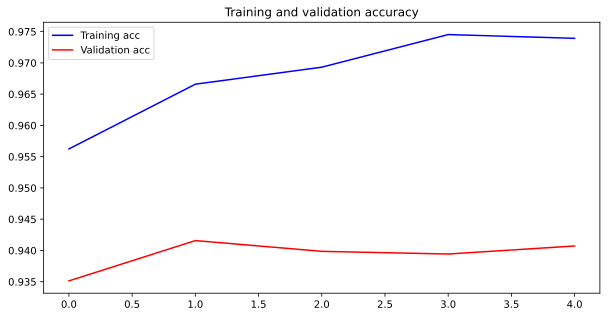

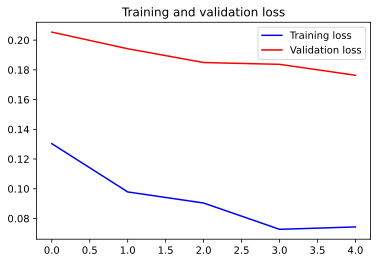

In [42]:
plot_history(history)

### Step 4

In [59]:
EPOCHS               = 10
BATCH_SIZE           = 4 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-5

IMG_SIZE             = 512
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [60]:
train_datagen = ImageDataGenerator(rescale=1. / 255, 
                                    rotation_range = 10,
                                    #shear_range=0.2,
                                    zoom_range=[0.75,1.25],
                                    #brightness_range=[0.5, 1.5],
                                    #width_shift_range=0.1,
                                    #height_shift_range=0.1,
                                   validation_split=VAL_SPLIT,
                                    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [61]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',  # директория где расположены папки с картинками
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    subset='training')  # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation')  # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [62]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [63]:
model.load_weights('best_model.hdf5')

In [64]:
# Обучаем
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/10
3308/3308 [==============================] - ETA: 0s - loss: 0.7170 - accuracy: 0.7962
Epoch 00001: saving model to best_model.hdf5
3308/3308 [==============================] - 1484s 449ms/step - loss: 0.7170 - accuracy: 0.7962 - val_loss: 0.2416 - val_accuracy: 0.9257
Epoch 2/10
3308/3308 [==============================] - ETA: 0s - loss: 0.4124 - accuracy: 0.8796
Epoch 00002: saving model to best_model.hdf5
3308/3308 [==============================] - 1421s 429ms/step - loss: 0.4124 - accuracy: 0.8796 - val_loss: 0.1691 - val_accuracy: 0.9463
Epoch 3/10
3308/3308 [==============================] - ETA: 0s - loss: 0.3369 - accuracy: 0.9009
Epoch 00003: saving model to best_model.hdf5
3308/3308 [==============================] - 1418s 429ms/step - loss: 0.3369 - accuracy: 0.9009 - val_loss: 0.1593 - val_accuracy: 0.9502
Epoch 4/10
3308/3308 [==============================] - ETA: 0s - loss: 0.2823 - accuracy: 0.9153
Epoch 00004: saving model to best_model.hdf5
3308/3308 [===

In [65]:
model.save('model_step4.hdf5')
model.load_weights('best_model.hdf5')

In [66]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

583/583 [==============================] - 139s 238ms/step - loss: 0.1149 - accuracy: 0.9631
Accuracy: 96.31%


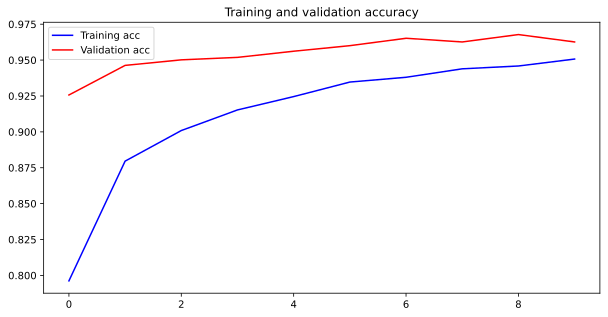

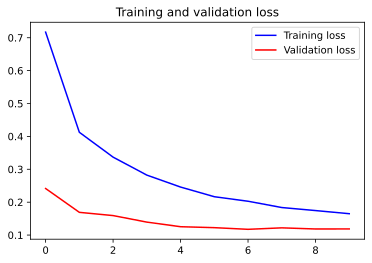

In [67]:
plot_history(history)

In [68]:
test_sub_generator.samples

6675

In [69]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

1669/1669 [==============================] - 120s 72ms/step


In [70]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [71]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,7
